<a href="https://colab.research.google.com/github/inesNeji/Multi-modal-emotion-recognition-/blob/main/BILSTM_DCNN_Emotion_Recg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d deadskull7/fer2013/download?datasetVersionNumber=1

 92% 89.0M/96.6M [00:01<00:00, 95.3MB/s]
100% 96.6M/96.6M [00:01<00:00, 89.0MB/s]


In [ ]:
!kaggle datasets download -d gauravsharma99/ck48-5-emotions

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 62.9MB/s]


In [ ]:
!unzip fer2013.zip

Archive:  fer2013.zip
  inflating: fer2013.csv             


In [ ]:
!unzip ck48-5-emotions.zip

In [ ]:
import os
import cv2
import numpy as np
from collections import defaultdict
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

In [ ]:
data_path = '/content/CK+48'
data_dir_list = os.listdir(data_path)

img_rows=256
img_cols=256
num_channel=1

num_epoch=10

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)

img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape



Loaded the images of dataset-happy

Loaded the images of dataset-surprise

Loaded the images of dataset-fear

Loaded the images of dataset-anger

Loaded the images of dataset-sadness



(750, 48, 48, 3)

In [ ]:
import pandas as pd
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [ ]:
import math
math.sqrt(len(df.pixels[0].split(' ')))

48.0

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape



(35887, 7)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 1), (3589, 48, 48, 1), (32298, 7), (3589, 7))

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
num_classes = 5

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:134]=0 #135
labels[135:188]=1 #54
labels[189:365]=2 #177
labels[366:440]=3 #75
labels[441:647]=4 #207


names = ['anger','fear','happy','sadness','surprise']

def getLabel(id):
    return ['anger','fear','happy','sadness','surprise'][id]



In [ ]:
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=2)
x_test= X_test

In [ ]:

input_shape=(48,48,1)

model = Sequential()
model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

In [ ]:
model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 6)         156       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 16)        2416      
                                                                 
 activation_4 (Activation)   (None, 24, 24, 16)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 12, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 10, 10, 64)       

True

In [ ]:


from keras import callbacks
filename='model_train_new.csv'
filepath="Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

csv_log=callbacks.CSVLogger(filename, separator=',', append=False)
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [csv_log,checkpoint]
callbacks_list = [csv_log]



In [ ]:
hist = model.fit(X_train, y_train,  batch_size=7, epochs=100, verbose=1, validation_data=(X_valid, y_valid),callbacks=callbacks_list)

Epoch 1/100
4614/4614 [==============================] - 17s 4ms/step - loss: 1.8215 - accuracy: 0.2484 - val_loss: 1.8124 - val_accuracy: 0.2505
Epoch 2/100
4614/4614 [==============================] - 16s 4ms/step - loss: 1.8133 - accuracy: 0.2505 - val_loss: 1.8112 - val_accuracy: 0.2505
Epoch 3/100
4614/4614 [==============================] - 16s 4ms/step - loss: 1.8118 - accuracy: 0.2505 - val_loss: 1.8110 - val_accuracy: 0.2505
Epoch 4/100
4614/4614 [==============================] - 18s 4ms/step - loss: 1.8117 - accuracy: 0.2505 - val_loss: 1.8114 - val_accuracy: 0.2505
Epoch 5/100
4614/4614 [==============================] - 17s 4ms/step - loss: 1.8119 - accuracy: 0.2505 - val_loss: 1.8108 - val_accuracy: 0.2505
Epoch 6/100
4614/4614 [==============================] - 16s 4ms/step - loss: 1.8116 - accuracy: 0.2505 - val_loss: 1.8106 - val_accuracy: 0.2505
Epoch 7/100
4614/4614 [==============================] - 16s 3ms/step - loss: 1.8113 - accuracy: 0.2505 - val_loss: 1.8108 -

KeyboardInterrupt: ignored

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

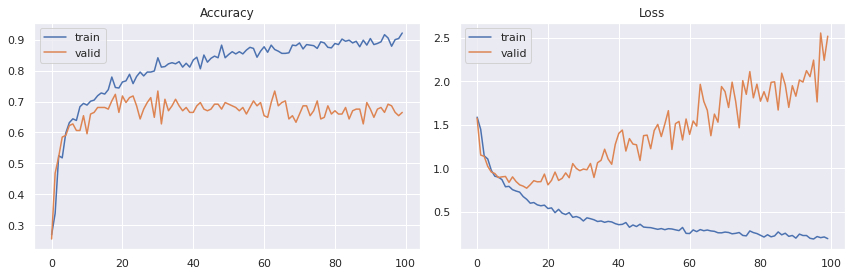

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(hist.epoch, hist.history['accuracy'], label='train')
sns.lineplot(hist.epoch, hist.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(hist.epoch, hist.history['loss'], label='train')
sns.lineplot(hist.epoch, hist.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix_1( cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
  plt.figure( figsize = ( 10, 6))

  plt.imshow( cm, interpolation='nearest', cmap=cmap)
  plt.title( title,  fontdict=dict( size=15))
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks( tick_marks, classes, rotation=45)
  plt.yticks( tick_marks, classes)

  thresh = cm.max() / 2.

  for i, j in itertools.product( range(cm.shape[0]), range(cm.shape[1])):
    plt.text( j, i, cm[i,j], horizontalalignment='center', color='white' if cm[i,j] > thresh else 'black')
    plt.grid(False)
  plt.tight_layout()
  plt.ylabel('True Label', fontdict=dict( size=15))
  plt.xlabel('Predicted Label', fontdict=dict( size=15))

18/18 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       101
           1       0.95      0.91      0.93       117
           2       0.97      0.91      0.94       132
           3       0.85      0.94      0.89        54
           4       0.99      0.99      0.99       158

    accuracy                           0.94       562
   macro avg       0.93      0.94      0.93       562
weighted avg       0.94      0.94      0.94       562



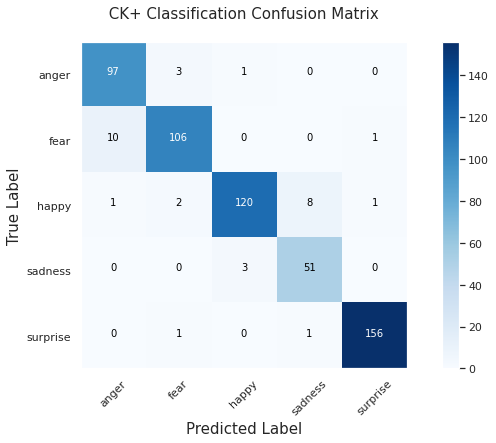

In [ ]:

yhat_valid =  np.argmax(model.predict(X_train), axis  =  -1)
y_true = np.argmax(y_train, axis = -1)
print(classification_report(y_true, yhat_valid))
Classes = { 1:'anger', 2:'fear', 3:'happy', 4:'sadness',5: 'surprise'}
cm= confusion_matrix(y_true, yhat_valid)
plot_confusion_matrix_1( cm, list(Classes.values()), title=' CK+ Classification Confusion Matrix \n')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
ypred = np.argmax(model.predict(x_test))

report  = classification_report(ypred, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix
results = model.predict(X_test)
cm = confusion_matrix(np.where(y_test == 1)[1], results)

In [ ]:
import scikitplot
#hat_valid = model.predict_classes(X_valid)
labels = ['anger','contempt','disgust','fear','happy','sadness','surprise']

conf = scikitplot.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), yhat_valid, figsize=(10,10),)
pyplot.savefig("confusion_matrix.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_test, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_test, axis=1), yhat_valid))
conf.xaxis.set_ticklabels(labels)
conf.yaxis.set_ticklabels(labels)

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print(model.predict(test_image))
print(model.predict(test_image))
print(y_test[0:1])

res = model.predict_classes(X_test[9:18])
plt.figure(figsize=(10, 10))

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_test[i],cmap=plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('prediction = %s' % getLabel(res[i]), fontsize=14)
# show the plot
plt.show()

In [ ]:
def build_dcnn( show_arch=True):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=(48,48,1),

            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.45, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.45, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.4, name='dropout_3'))

    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_7'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_8'
        )
    )
    net.add(BatchNormalization(name='batchnorm_8'))

    net.add(Dropout(0.4, name='dropout_4'))

    net.add(GlobalMaxPool2D(name="globalmax2d"))

    if show_arch:
        net.summary()

    return net

In [ ]:
def memory_model(num_class, show_arch=True):
    dcnn = build_dcnn(show_arch=False)

    model = Sequential(name="convolutional_Bidrectional_LSTM")

    model.add(
        TimeDistributed(
            dcnn,
            input_shape=(48,48,1)
,
            name="time_distributed",
        )
    )

    model.add(Bidirectional(LSTM(128, return_sequences=True, name="bidirect_lstm_1")))
    model.add(Dropout(.35, name="dropout_1"))
    model.add(Bidirectional(LSTM(64, return_sequences=False, name="bidirect_lstm_2")))
    model.add(Dropout(.45, name="dropout_2"))

    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(Dropout(.6, name="dropout_3"))

    model.add(
        Dense(
            num_class,
            activation='softmax',
            name='out_layer'
        )
    )

    if show_arch:
        model.summary()

    return model

In [ ]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    lr_scheduler,
]

batch_size = 32
epochs = 300

In [ ]:
input_shape=(48, 48, 3)
optim = optimizers.Nadam(0.001)

model = memory_model( num_class=7)
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)



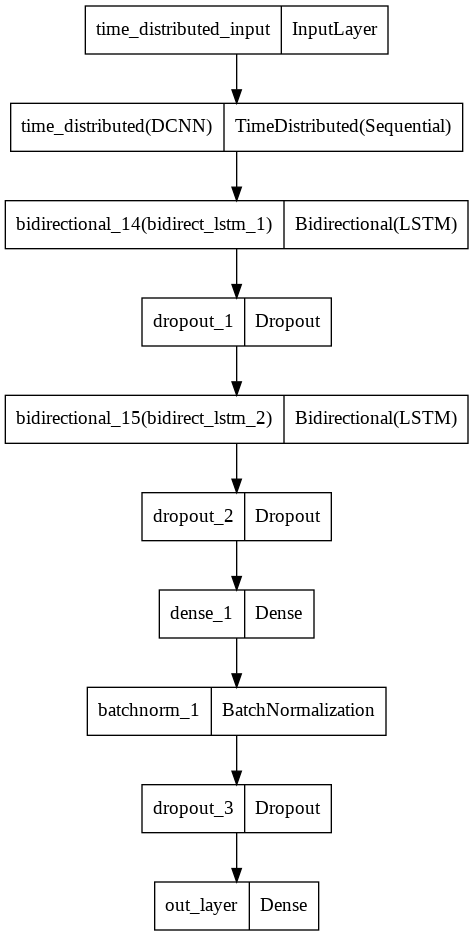

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False)

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=100,
    use_multiprocessing=True
)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

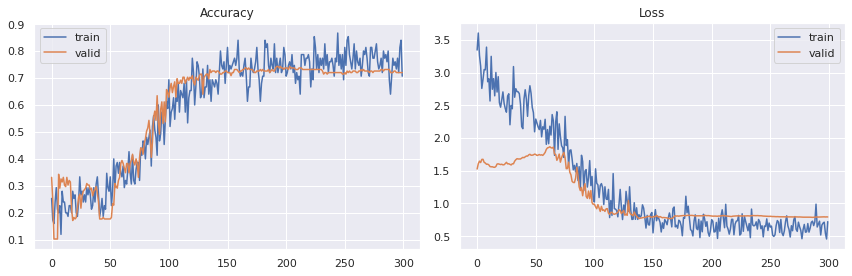

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()

In [ ]:
yhat_valid =  np.argmax(model.predict(X_valid), axis  =  1)
y_true = np.argmax(X_train, axis = 1)

In [ ]:
pip install scikit-plot


In [ ]:
import scikitplot

total wrong validation predictions: 49


              precision    recall  f1-score   support

           0       0.98      0.86      0.92        58
           1       0.80      0.98      0.88        48
           2       0.46      0.94      0.62        31
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        18

    accuracy                           0.72       175
   macro avg       0.45      0.56      0.48       175
weighted avg       0.62      0.72      0.65       175



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0, 0, 'happy'),
 Text(0, 1, 'surprise'),
 Text(0, 2, 'anger'),
 Text(0, 3, 'sadness'),
 Text(0, 4, 'fear')]

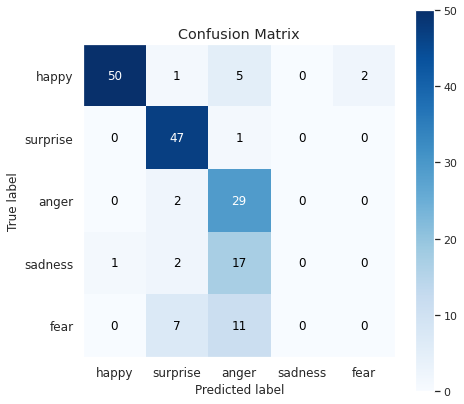

In [ ]:
#hat_valid = model.predict_classes(X_valid)
labels = ["happy", "surprise", "anger", "sadness", "fear"]
conf = scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7),)
pyplot.savefig("confusion_matrix.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))
conf.xaxis.set_ticklabels(labels)
conf.yaxis.set_ticklabels(labels)

In [ ]:
y_pred =   np.argmax(new_model.predict(X_test_pad), axis  =  1)
y_true = np.argmax(y_test, axis = 1)

In [ ]:
np.random.seed(0)
indices = np.random.choice(range(X_valid.shape[0]-60), size=15, replace=False)

fig = pyplot.figure(1, (9,30))

i = 0
for idx in indices:
    true_emotion = label_emotion_mapper[np.argmax(y_valid[idx])]
    pred_emotion = label_emotion_mapper[np.argmax(model.predict(np.expand_dims(X_valid[idx], axis=0)))]

    for j in range(1):
        i += 1
        ax = pyplot.subplot(15,2,i)
        sample_img = X_valid[idx,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f" T:{true_emotion},P:{pred_emotion}")

In [ ]:
input_shape=(48,48,3)

model = Sequential()
model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')


In [ ]:
model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 48, 6)         456       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 16)        2416      
                                                                 
 activation (Activation)     (None, 24, 24, 16)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)       

True